

<img src="images/ProjectPythia_Logo_Final-01-Blue.svg" width=250 alt="Project Pythia Logo"></img>

# Full stack example: download to display
## GOES-16 Advanced Baseline Imager (ABI) data 

Obtained from AWS archives, processed with Satpy. Uses hardwired AWS filenames, not easily adjusted. For realtime AWS access without downloading, see AWS_access_cookbook in this directory. An archival version of that for specified dates/times is a to-do list item, for which (SatPy remote reading)[https://satpy.readthedocs.io/en/latest/remote_reading.html] is a useful resource.

---

## Overview
[*Satpy*](https://satpy.readthedocs.io/en/stable/overview.html) is a package to efficiently access, evaluate, and visualize satellite imagery. Advanced Baseline Imager (ABI) data are fetched from AWS. A Satpy **Scene** object encompasses the ABI data file(s), and the relevant data are then loaded in as needed for visualization. These tools open a world of possibilities for everything from environmental research to weather monitoring.

## Prerequisites

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Info</p>
    Some prerequisites to understanding Satpy effectively:
</div>


1. **Basic Python:** Users should comprehend ideas such as variables, data types including objects, loops, functions, and libraries/modules.

1. **Knowledge of Satellite Data:** Basic familiarity with satellite instruments, data formats, and the different kinds of data that satellites gather.

1. **Concepts of Data Processing:** Reading, modifying, and visualizing data. 

1. **Python Libraries:** It can be helpful to have some knowledge of other Python libraries that are frequently used in scientific computing, such as NumPy, Matplotlib, and Pandas. These libraries are frequently integrated with Satpy for tasks involving data manipulation and visualization.

------
# Initial imports of libraries 

In [47]:
# To stop extraneous warning messages from clogging the notebook output, 
# import the warnings module and set it to ignore all warnings.
import warnings
warnings.filterwarnings('ignore')

import requests
import os
from datetime import datetime
from glob import glob  # file handling

# Scene is a representation of satellite data 
from satpy.scene import Scene
# enable detailed debug logging in Satpy. 
from satpy.utils import debug_on

import matplotlib.pyplot as plt

--------
# Next, download some data
### No need to repeat this step more than once 

Key parts of filename **OR_ABI-L1b-RadF-M6C01_G16** : 

Full disk radiances **RadF** or CONUS **RadC**, channel **C01** from GOES **G16** satellite. 

Time stamps are YYYYjjjhhmm where *jjj* is Julian day of year



In [26]:
### List of files to download for testing

# these are all the 16 spectral channels at one time, C01-C16
# Channels described at https://www.goes-r.gov/mission/ABI-bands-quick-info.html
# Full disk channel C02 (red visible) is much bigger (350MB) than the others (10-40MB each)
# Conus (radC) is more reasonable for an example 

### List of files to download for testing
urls2dwn = [ 
  'https://noaa-goes16.s3.amazonaws.com/ABI-L1b-RadC/2023/256/15/OR_ABI-L1b-RadC-M6C01_G16_s20232561536173_e20232561538548_c20232561538585.nc',
  'https://noaa-goes16.s3.amazonaws.com/ABI-L1b-RadC/2023/256/15/OR_ABI-L1b-RadC-M6C02_G16_s20232561536173_e20232561538546_c20232561538578.nc',
  'https://noaa-goes16.s3.amazonaws.com/ABI-L1b-RadC/2023/256/15/OR_ABI-L1b-RadC-M6C03_G16_s20232561536173_e20232561538546_c20232561538589.nc',
  'https://noaa-goes16.s3.amazonaws.com/ABI-L1b-RadC/2023/256/15/OR_ABI-L1b-RadC-M6C04_G16_s20232561536173_e20232561538546_c20232561539001.nc',
  'https://noaa-goes16.s3.amazonaws.com/ABI-L1b-RadC/2023/256/15/OR_ABI-L1b-RadC-M6C05_G16_s20232561536173_e20232561538546_c20232561539016.nc',
  'https://noaa-goes16.s3.amazonaws.com/ABI-L1b-RadC/2023/256/15/OR_ABI-L1b-RadC-M6C06_G16_s20232561536173_e20232561538551_c20232561539011.nc',
  'https://noaa-goes16.s3.amazonaws.com/ABI-L1b-RadC/2023/256/15/OR_ABI-L1b-RadC-M6C07_G16_s20232561536173_e20232561538557_c20232561539026.nc',
  'https://noaa-goes16.s3.amazonaws.com/ABI-L1b-RadC/2023/256/15/OR_ABI-L1b-RadC-M6C08_G16_s20232561536173_e20232561538546_c20232561538598.nc',
  'https://noaa-goes16.s3.amazonaws.com/ABI-L1b-RadC/2023/256/15/OR_ABI-L1b-RadC-M6C09_G16_s20232561536173_e20232561538551_c20232561538580.nc',
  'https://noaa-goes16.s3.amazonaws.com/ABI-L1b-RadC/2023/256/15/OR_ABI-L1b-RadC-M6C10_G16_s20232561536173_e20232561538557_c20232561539020.nc',
  'https://noaa-goes16.s3.amazonaws.com/ABI-L1b-RadC/2023/256/15/OR_ABI-L1b-RadC-M6C11_G16_s20232561536173_e20232561538546_c20232561539034.nc',
  'https://noaa-goes16.s3.amazonaws.com/ABI-L1b-RadC/2023/256/15/OR_ABI-L1b-RadC-M6C12_G16_s20232561536173_e20232561538552_c20232561539031.nc',
  'https://noaa-goes16.s3.amazonaws.com/ABI-L1b-RadC/2023/256/15/OR_ABI-L1b-RadC-M6C13_G16_s20232561536173_e20232561538557_c20232561539004.nc',
  'https://noaa-goes16.s3.amazonaws.com/ABI-L1b-RadC/2023/256/15/OR_ABI-L1b-RadC-M6C14_G16_s20232561536173_e20232561538546_c20232561538592.nc',
  'https://noaa-goes16.s3.amazonaws.com/ABI-L1b-RadC/2023/256/15/OR_ABI-L1b-RadC-M6C15_G16_s20232561536173_e20232561538551_c20232561539007.nc',
  'https://noaa-goes16.s3.amazonaws.com/ABI-L1b-RadC/2023/256/15/OR_ABI-L1b-RadC-M6C16_G16_s20232561536173_e20232561538557_c20232561539036.nc']

# Specify the local directory where you want to save the files.

local_directory = "Downloaded_data/ABI-L1b-RadC/s20210992350171"

# Create your directory for data 
os.makedirs(local_directory, exist_ok=True)

# Iterate through the URLs and download files to local directory

for urld in urls2dwn:
    # Extract the filename from the URL.
    ntw = urld.split('/')[-1]
    
    # Construct the complete path to save the file in the local directory.
    file_path = os.path.join(local_directory, ntw)
    
    # Send an HTTP GET request to the URL.
    resp = requests.get(urld)
    
    # Check if the response is successful (status code 200).
    if resp.status_code == 200:
    # Write the content to the file in binary mode.
        with open(file_path, "wb") as file:
            file.write(resp.content)
        print(f"File '{ntw}' downloaded and saved to '{local_directory}'.")
    else:
        print(f"Failed to download '{ntw}' from the URL: {urld}")

File 'OR_ABI-L1b-RadC-M6C01_G16_s20232561536173_e20232561538548_c20232561538585.nc' downloaded and saved to 'Output_data/ABI-L1b-RadC/s20210992350171'.
File 'OR_ABI-L1b-RadC-M6C02_G16_s20232561536173_e20232561538546_c20232561538578.nc' downloaded and saved to 'Output_data/ABI-L1b-RadC/s20210992350171'.
File 'OR_ABI-L1b-RadC-M6C03_G16_s20232561536173_e20232561538546_c20232561538589.nc' downloaded and saved to 'Output_data/ABI-L1b-RadC/s20210992350171'.
File 'OR_ABI-L1b-RadC-M6C04_G16_s20232561536173_e20232561538546_c20232561539001.nc' downloaded and saved to 'Output_data/ABI-L1b-RadC/s20210992350171'.
File 'OR_ABI-L1b-RadC-M6C05_G16_s20232561536173_e20232561538546_c20232561539016.nc' downloaded and saved to 'Output_data/ABI-L1b-RadC/s20210992350171'.
File 'OR_ABI-L1b-RadC-M6C06_G16_s20232561536173_e20232561538551_c20232561539011.nc' downloaded and saved to 'Output_data/ABI-L1b-RadC/s20210992350171'.
File 'OR_ABI-L1b-RadC-M6C07_G16_s20232561536173_e20232561538557_c20232561539026.nc' down

--------
# List available channels, and create satpy Scene object

In [31]:
sat_files = glob(local_directory+'/*')
sat_files.sort()
sat_files

['Downloaded_data/ABI-L1b-RadC/s20210992350171/OR_ABI-L1b-RadC-M6C01_G16_s20232561536173_e20232561538548_c20232561538585.nc',
 'Downloaded_data/ABI-L1b-RadC/s20210992350171/OR_ABI-L1b-RadC-M6C02_G16_s20232561536173_e20232561538546_c20232561538578.nc',
 'Downloaded_data/ABI-L1b-RadC/s20210992350171/OR_ABI-L1b-RadC-M6C03_G16_s20232561536173_e20232561538546_c20232561538589.nc',
 'Downloaded_data/ABI-L1b-RadC/s20210992350171/OR_ABI-L1b-RadC-M6C04_G16_s20232561536173_e20232561538546_c20232561539001.nc',
 'Downloaded_data/ABI-L1b-RadC/s20210992350171/OR_ABI-L1b-RadC-M6C05_G16_s20232561536173_e20232561538546_c20232561539016.nc',
 'Downloaded_data/ABI-L1b-RadC/s20210992350171/OR_ABI-L1b-RadC-M6C06_G16_s20232561536173_e20232561538551_c20232561539011.nc',
 'Downloaded_data/ABI-L1b-RadC/s20210992350171/OR_ABI-L1b-RadC-M6C07_G16_s20232561536173_e20232561538557_c20232561539026.nc',
 'Downloaded_data/ABI-L1b-RadC/s20210992350171/OR_ABI-L1b-RadC-M6C08_G16_s20232561536173_e20232561538546_c202325615385

In [34]:
# Create a Scene object named 'scn' 
# The Scene object is a core part of the Satpy library.
# In its internal naming, spectral channels are called "dataset_names"

scn = Scene(filenames = sat_files, reader='abi_l1b')

# Retrieve the names of all datasets available in the 'scn' object, which represent various satellite data channels.
dataset_names = scn.all_dataset_names()

# Output the list of dataset names. 
print(dataset_names)

['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16']


In [35]:
# Load those datasets, using a list comprehension to generate dataset names.
# In this case, we generate names for the datasets 'C01' to 'C16', which are typical channel identifiers in satellite data.
scn.load([f'C{x:02d}' for x in range(1, 17)])

# Explanation of the list comprehension:
# [f'C{x:02d}' for x in range(1, 17)] creates a list of strings from 'C01' to 'C16'.
# 'f' before the string starts an f-string, allowing us to insert variables directly into the string.
# '{x:02d}' formats the number 'x' as a two-digit decimal, padding with zeros if necessary.

# The 'scn.load' function is then used to load these specific datasets into the Scene object.
# Loading multiple channels like this is common in the analysis of satellite imagery,
# where each channel can represent different spectral bands and contain different types of environmental information.

## Within a satpy Scene, multi-channel *composite* products can be constructed

In [36]:
# This method retrieves a list of all the composite images that can be created using the loaded data channels.
print(scn.available_composite_names())

# Composite images are made by combining multiple data channels to enhance the visualization and interpretation of satellite data.

['airmass', 'ash', 'cimss_cloud_type', 'cimss_cloud_type_raw', 'cimss_green', 'cimss_green_sunz', 'cimss_green_sunz_rayleigh', 'cimss_true_color', 'cimss_true_color_sunz', 'cimss_true_color_sunz_rayleigh', 'cira_day_convection', 'cira_fire_temperature', 'cloud_phase', 'cloud_phase_distinction', 'cloud_phase_distinction_raw', 'cloud_phase_raw', 'cloudtop', 'color_infrared', 'colorized_ir_clouds', 'convection', 'day_microphysics', 'day_microphysics_abi', 'day_microphysics_eum', 'dust', 'fire_temperature_awips', 'fog', 'green', 'green_crefl', 'green_nocorr', 'green_raw', 'green_snow', 'highlight_C14', 'ir108_3d', 'ir_cloud_day', 'land_cloud', 'land_cloud_fire', 'natural_color', 'natural_color_nocorr', 'natural_color_raw', 'natural_color_raw_with_night_ir', 'night_fog', 'night_ir_alpha', 'night_ir_with_background', 'night_ir_with_background_hires', 'night_microphysics', 'night_microphysics_abi', 'overview', 'overview_raw', 'rocket_plume_day', 'rocket_plume_night', 'snow', 'snow_fog', 'so2'

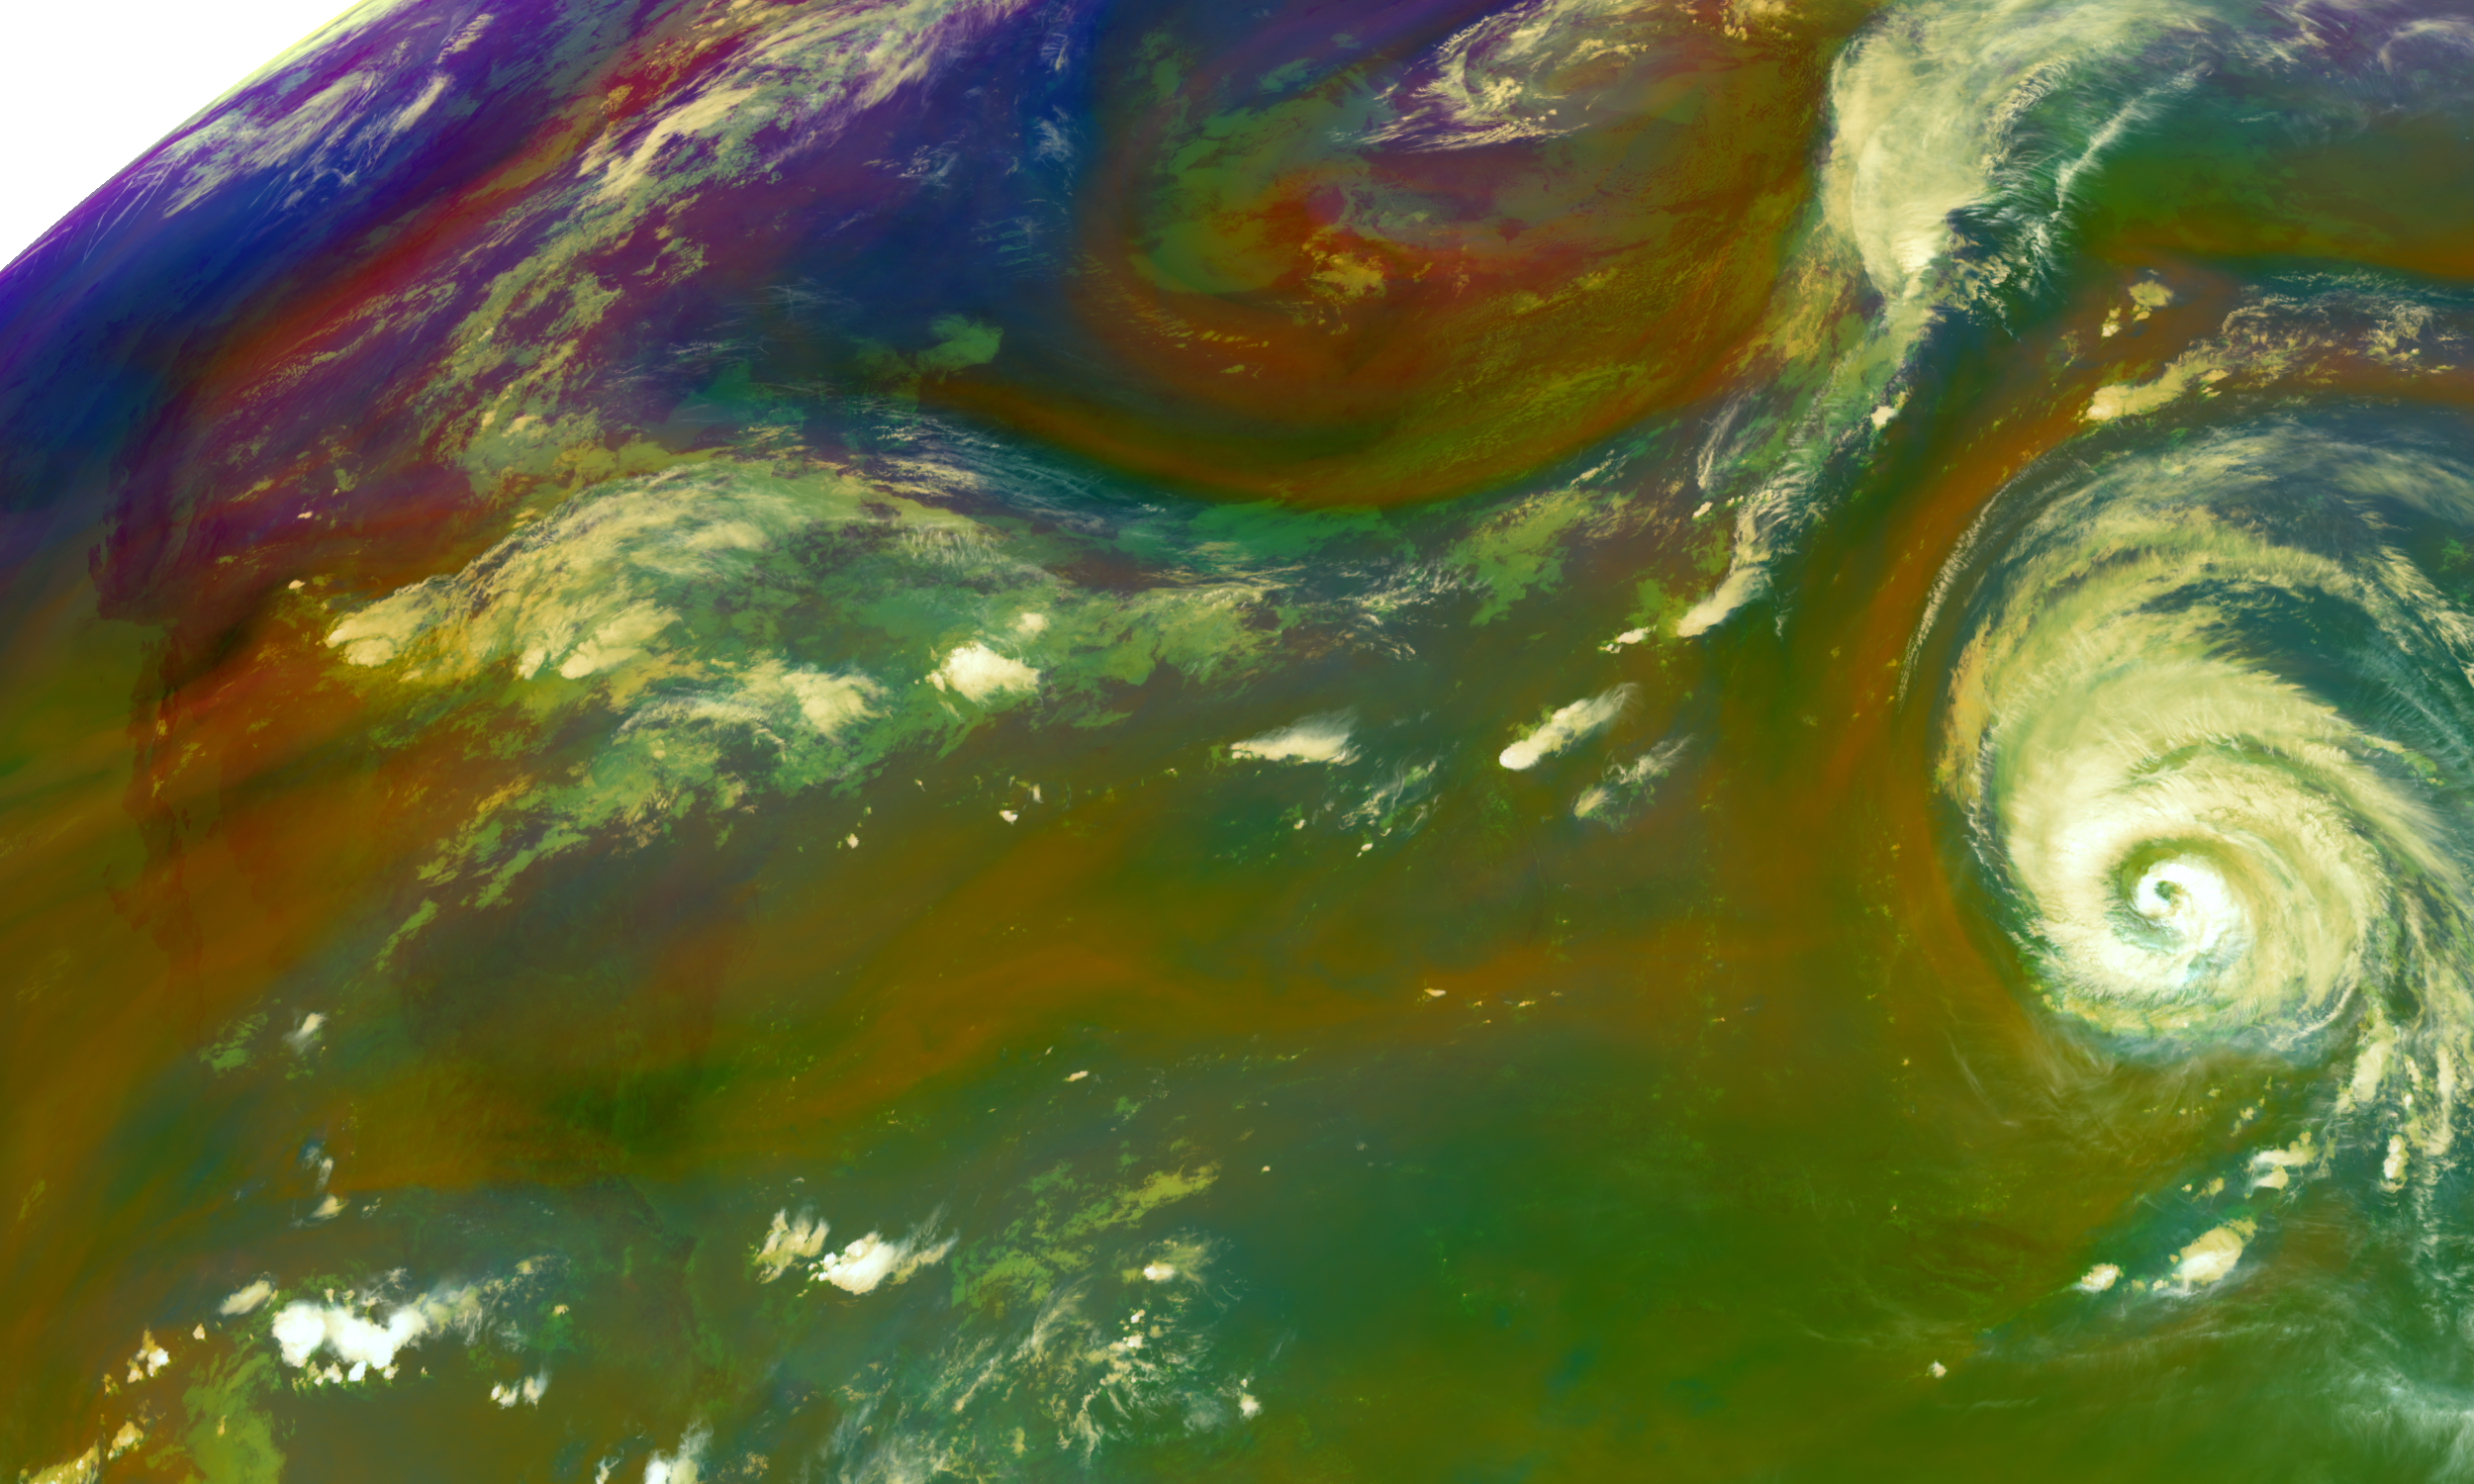

In [42]:
# Assign the composite name 'airmass' to the variable 'rgb_im' for Red-Green-Blue Image
rgb_im = 'airmass'
scn.load([rgb_im])

# The 'airmass' composite is particularly useful in meteorology 
# It combines several spectral bands to highlight features like dust, ash, and water vapor

# Display the loaded 'airmass' dataset using 'scn.show'.
scn.show(rgb_im, overlay=None)

# For a map overlay, see https://satpy.readthedocs.io/en/latest/api/satpy.scene.html#satpy.scene.Scene.show

In [44]:
# What is this new internal Scene data object, scn[rgb_im] ? 

# Answer: an xarray DataArray with 3 bands (R,G,B)

scn[rgb_im]

<xarray.DataArray 'where-87e8d4567236dee30a0ea0adce56f209' (bands: 3, y: 1500,
                                                            x: 2500)>
dask.array<where, shape=(3, 1500, 2500), dtype=float64, chunksize=(1, 1500, 2500), chunktype=numpy.ndarray>
Coordinates:
    crs      object PROJCRS["unknown",BASEGEOGCRS["unknown",DATUM["unknown",E...
  * y        (y) float64 4.588e+06 4.586e+06 4.584e+06 ... 1.586e+06 1.584e+06
  * x        (x) float64 -3.626e+06 -3.624e+06 -3.622e+06 ... 1.38e+06 1.382e+06
  * bands    (bands) <U1 'R' 'G' 'B'
Attributes: (12/29)
    instrument_ID:           FM1
    scan_mode:               M6
    scene_abbr:              C
    production_site:         WCDAS
    platform_name:           GOES-16
    cell_methods:            t: point area: point
    ...                      ...
    optional_datasets:       []
    name:                    airmass
    _satpy_id:               DataID(name='airmass', resolution=2000)
    prerequisites:           [DataQuery(name='_airmass_dep_0'), DataQuery(nam...
    optional_prerequisites:  []
    mode:                    RGB

In [ ]:
# A closer look: scn[rgb_im] is 3 arrays, red green and blue

plt.figure( figsize=(10,3) )

plt.subplot(131)
scn[rgb_im][0].plot( cmap='Reds')
plt.subplot(132)
scn[rgb_im][1].plot( cmap='Greens')
plt.subplot(133)
scn[rgb_im][2].plot( cmap='Blues')

plt.tight_layout()

In [ ]:
# The individual channels are in there too, like 'C02' and 'C08', and are simply 2D DataArrays 

# Channels 1-7 are reflected sunlight (reflectance, brighter is white)
# 8-16 are infrared emissions (brightness temperature units, colder is white) 
# Illustrate one example of each 

plt.figure( figsize=(10,4) )

plt.subplot(121)
scn['C02'].plot( cmap='Greys_r' ); plt.title('Red visible band');

plt.subplot(122)
scn['C08'].plot( cmap='Greys' ); plt.title('Water Vapor infrared band');

In [71]:
# Retrieve the keys (dataset names) available in the 'scn' object: 
# All the imported channels, and any newly created composites like our 'airmass'

scn.keys()

# The output is a list of DataID objects, each encapsulating the metadata for a different satellite data channel or composite.
# These DataIDs include crucial information such as:
# - name: The identifier of the dataset, like 'C01', 'C02', ..., 'C16', 'airmass'.
# - wavelength: A WavelengthRange object indicating the spectral range each channel covers, important for identifying the type of observations (e.g., visible, infrared).
# - resolution: The spatial resolution of the data in meters, which affects the detail level visible in the imagery.
# - calibration: The type of calibration applied to the data, which could be reflectance or brightness temperature, impacting how the data should be interpreted.
# - modifiers: Any additional processing applied to the data channel.

[DataID(name='C01', wavelength=WavelengthRange(min=0.45, central=0.47, max=0.49, unit='µm'), resolution=1000, calibration=<calibration.reflectance>, modifiers=()),
 DataID(name='C02', wavelength=WavelengthRange(min=0.59, central=0.64, max=0.69, unit='µm'), resolution=500, calibration=<calibration.reflectance>, modifiers=()),
 DataID(name='C03', wavelength=WavelengthRange(min=0.8455, central=0.865, max=0.8845, unit='µm'), resolution=1000, calibration=<calibration.reflectance>, modifiers=()),
 DataID(name='C04', wavelength=WavelengthRange(min=1.3705, central=1.378, max=1.3855, unit='µm'), resolution=2000, calibration=<calibration.reflectance>, modifiers=()),
 DataID(name='C05', wavelength=WavelengthRange(min=1.58, central=1.61, max=1.64, unit='µm'), resolution=1000, calibration=<calibration.reflectance>, modifiers=()),
 DataID(name='C06', wavelength=WavelengthRange(min=2.225, central=2.25, max=2.275, unit='µm'), resolution=2000, calibration=<calibration.reflectance>, modifiers=()),
 Data

In [73]:
# Access the area information associated with the 'C13' dataset in the 'scn' object.
# The area property of a dataset within a Scene object provides geographical and geometric details about the satellite data.
# This includes information such as the projection, extent, resolution, and size of the dataset, which are crucial for spatial analysis.

scn["C13"].area


Area ID: GOES-East
Description: 2km at nadir
Projection ID: abi_fixed_grid
Projection: {'ellps': 'GRS80', 'h': '35786023', 'lon_0': '-75', 'no_defs': 'None', 'proj': 'geos', 'sweep': 'x', 'type': 'crs', 'units': 'm', 'x_0': '0', 'y_0': '0'}
Number of columns: 2500
Number of rows: 1500
Area extent: (-3627271.2913, 1583173.6575, 1382771.9287, 4589199.5895)

In [78]:
# The 'C02' channel (red visible) yas the highest resolution, note 
# higher Number of Columns, Number of Rows

scn["C02"].area


Area ID: GOES-East
Description: 0.5km at nadir
Projection ID: abi_fixed_grid
Projection: {'ellps': 'GRS80', 'h': '35786023', 'lon_0': '-75', 'no_defs': 'None', 'proj': 'geos', 'sweep': 'x', 'type': 'crs', 'units': 'm', 'x_0': '0', 'y_0': '0'}
Number of columns: 10000
Number of rows: 6000
Area extent: (-3627271.2913, 1583173.6575, 1382771.9287, 4589199.5895)

---------
# Natural Color (red, blue, veggie=green) 
## Notice that these have different resolutions so it gives an error

In [82]:
# Create the "natural_color" composite using the 'scn.load' method.
# The "natural_color" composite is a popular visual representation that combines multiple spectral bands
# to produce an image that approximates what the human eye would see from space. 
# The composite typically leverages red, green, and blue spectral bands to enhance the clarity and detail of the image,
# which makes it ideal for presentations, educational purposes, and initial visual assessments in environmental studies.

scn.load(['natural_color'])

The following datasets were not created and may require resampling to be generated: DataID(name='natural_color')


## To fix the error, we need to resample to a lowest common resolution
#### IR channels like 13 have low resolution, let's use that 

In [86]:
# Resample Scale rs 

rs = scn["C13"].area

# Resample the scene to the specified area definition.

lscn = scn.resample(rs)

# The resulting 'lscn' is a new Scene object containing all the original data, 
# resampled to the area properties (pixel size, etc.) of rs

In [ ]:
# Load and display the "natural_color" composite dataset for the resampled (lower-res) scene.

lscn.load(["natural_color"])
lscn.show("natural_color")

# Cropping to a smaller region 

In [93]:
lscn["C13"].area

Area ID: GOES-East
Description: 2km at nadir
Projection ID: abi_fixed_grid
Projection: {'ellps': 'GRS80', 'h': '35786023', 'lon_0': '-75', 'no_defs': 'None', 'proj': 'geos', 'sweep': 'x', 'type': 'crs', 'units': 'm', 'x_0': '0', 'y_0': '0'}
Number of columns: 2500
Number of rows: 1500
Area extent: (-3627271.2913, 1583173.6575, 1382771.9287, 4589199.5895)

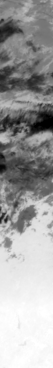

In [101]:
# Crop the resampled scene (lscn) to a specific geographic region defined by latitude and longitude bounds.

# The bounds are given as a tuple in the format (lon_min, lat_min, lon_max, lat_max).
# Lat-Lon scropping seems not to work right... need to study the docs more 
# https://satpy.readthedocs.io/en/latest/quickstart.html#slicing-and-subsetting-scenes

scn_c1 = lscn.crop(ll_bbox=(-99.7, 25.7, -35.9, 30.1))

scn_c1.show("C13")


----------
# A couple of other false-color products 

In [ ]:
# Load the "ash" dataset from the cropped scene (scn_c1).
# The "ash" composite is specifically designed to detect and visualize volcanic ash in the atmosphere using satellite data.

scn.load(['ash'])
scn.show('ash')

In [ ]:
# Load the "so2" dataset from the cropped scene (scn_c1).
# The "so2" dataset is designed to detect sulfur dioxide (SO2) concentrations in the atmosphere using satellite data.
# SO2 is a significant volcanic gas and industrial pollutant, making this dataset crucial for monitoring air quality and volcanic activity.

scn.load(['so2'])
scn.show('so2')

# This step not only aids in the educational demonstration of how satellite imagery can be utilized to monitor environmental pollutants but also provides practical insights into the management of air quality.
# Such visualizations are valuable tools for researchers, policymakers, and educators in understanding and addressing atmospheric pollution.

### A content subsection
Divide and conquer your objectives with Markdown subsections, which will populate the helpful navbar in Jupyter Lab and here on the Jupyter Book!

In [ ]:
# some subsection code
new = "helpful information"

### Another content subsection
Keep up the good work! A note, *try to avoid using code comments as narrative*, and instead let them only exist as brief clarifications where necessary.

## Your second content section
Here we can move on to our second objective, and we can demonstrate

### Subsection to the second section

#### a quick demonstration

##### of further and further

###### header levels

as well $m = a * t / h$ text! Similarly, you have access to other $\LaTeX$ equation [**functionality**](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Typesetting%20Equations.html) via MathJax (demo below from link),

\begin{align}
\dot{x} & = \sigma(y-x) \\
\dot{y} & = \rho x - y - xz \\
\dot{z} & = -\beta z + xy
\end{align}

Check out [**any number of helpful Markdown resources**](https://www.markdownguide.org/basic-syntax/) for further customizing your notebooks and the [**Jupyter docs**](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html) for Jupyter-specific formatting information. Don't hesitate to ask questions if you have problems getting it to look *just right*.

## Last Section

If you're comfortable, and as we briefly used for our embedded logo up top, you can embed raw html into Jupyter Markdown cells (edit to see):

> [!NOTE]  
> Highlights information that users should take into account, even when skimming.

> [!TIP]
> Optional information to help a user be more successful.

> [!IMPORTANT]  
> Crucial information necessary for users to succeed.

> [!WARNING]  
> Critical content demanding immediate user attention due to potential risks.

> [!CAUTION]
> Negative potential consequences of an action.

<div class="admonition note">
<p class="admonition-title">Note</p>
<p>You should note that the title will be automatically capitalized.</p>
</div>

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Info</p>
    Your relevant information here!
</div>

Feel free to copy this around and edit or play around with yourself. Some other `admonitions` you can put in:

<div class="admonition alert alert-success">
    <p class="admonition-title" style="font-weight:bold">Success</p>
    We got this done after all!
</div>

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Warning</p>
    Be careful!
</div>

<div class="admonition alert alert-danger">
    <p class="admonition-title" style="font-weight:bold">Danger</p>
    Scary stuff be here.
</div>

We also suggest checking out Jupyter Book's [brief demonstration](https://jupyterbook.org/content/metadata.html#jupyter-cell-tags) on adding cell tags to your cells in Jupyter Notebook, Lab, or manually. Using these cell tags can allow you to [customize](https://jupyterbook.org/interactive/hiding.html) how your code content is displayed and even [demonstrate errors](https://jupyterbook.org/content/execute.html#dealing-with-code-that-raises-errors) without altogether crashing our loyal army of machines!